Epoch 1: Train=1406.1636 Val=1436.6733
Epoch 2: Train=1163.6282 Val=1323.8665
Epoch 3: Train=943.8475 Val=1230.7732
Epoch 4: Train=859.3506 Val=1140.9681
Epoch 5: Train=832.4313 Val=1054.1771
Epoch 6: Train=731.3141 Val=969.3293
Epoch 7: Train=690.7781 Val=886.4670
Epoch 8: Train=611.7432 Val=807.4102
Epoch 9: Train=509.4209 Val=734.4137
Epoch 10: Train=472.0329 Val=666.8690
Epoch 11: Train=393.2164 Val=603.8282
Epoch 12: Train=351.9157 Val=550.4356
Epoch 13: Train=350.6101 Val=503.9716
Epoch 14: Train=281.0710 Val=458.0013
Epoch 15: Train=288.7900 Val=416.0943
Epoch 16: Train=214.2746 Val=378.8326
Epoch 17: Train=186.1830 Val=342.3366
Epoch 18: Train=167.0242 Val=312.4503
Epoch 19: Train=148.7663 Val=286.4774
Epoch 20: Train=275.8041 Val=263.6446
Epoch 21: Train=113.9473 Val=246.2948
Epoch 22: Train=109.5431 Val=225.1359
Epoch 23: Train=109.9544 Val=209.4062
Epoch 24: Train=86.3309 Val=196.8220
Epoch 25: Train=96.3768 Val=186.6330
Epoch 26: Train=79.7006 Val=178.7001
Epoch 27: Train=7

C:\Users\islam\AppData\Local\Temp\ipykernel_4016\3524100960.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_nn.pth"))


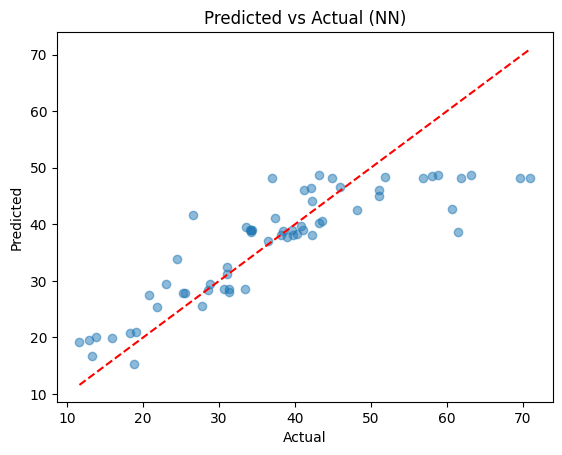

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------
# Load Data
# ----------------------------
X_train = pd.read_csv("train_filtered.csv")
X_val   = pd.read_csv("val_filtered.csv")
X_test  = pd.read_csv("test_filtered.csv")

y_train = pd.read_csv("y_train.csv").squeeze()
y_val   = pd.read_csv("y_val.csv").squeeze()
y_test  = pd.read_csv("y_test.csv").squeeze()

# ----------------------------
# Dataset Class
# ----------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
val_ds   = TabularDataset(X_val, y_val)
test_ds  = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

# ----------------------------
# Strong Neural Network
# ----------------------------
class StrongNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(0.25),

            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(0.20),

            nn.Linear(256, 128),
            nn.GELU(),
            nn.LayerNorm(128),
            nn.Dropout(0.15),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = StrongNN(X_train.shape[1]).to(device)

# ----------------------------
# Training Setup
# ----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=6, factor=0.5
)

# ----------------------------
# Train Loop
# ----------------------------
best_val = float("inf")
epochs = 200
history = {"train": [], "val": []}

early_stop = 0

for epoch in range(epochs):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        pred = model(xb)
        loss = criterion(pred, yb)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train={train_loss:.4f} Val={val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_nn.pth")
        early_stop = 0
    else:
        early_stop += 1

    if early_stop > 15:
        print("Early Stopping Activated")
        break

# Load best model
model.load_state_dict(torch.load("best_nn.pth"))

# ----------------------------
# Evaluate
# ----------------------------
def evaluate(loader):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())

    preds = np.concatenate(preds).ravel()
    trues = np.concatenate(trues).ravel()

    metrics = {
        "RMSE": np.sqrt(mean_squared_error(trues, preds)),
        "MAE": mean_absolute_error(trues, preds),
        "R2": r2_score(trues, preds),
    }
    return metrics, trues, preds

train_m, _, _ = evaluate(train_loader)
val_m, _, _ = evaluate(val_loader)
test_m, y_true, y_pred = evaluate(test_loader)

print("\n===== METRICS =====")
print("Train:", train_m)
print("Val:", val_m)
print("Test:", test_m)

# ----------------------------
# Plot Predicted vs Actual
# ----------------------------
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (NN)")
plt.show()
